<a
href="https://colab.research.google.com/github/wingated/cs474_labs_f2019/blob/master/DL_Lab10.ipynb"
  target="_parent">
  <img
    src="https://colab.research.google.com/assets/colab-badge.svg"
    alt="Open In Colab"/>
</a>

Tilt Wake Model

### Objective

- Apply DNN to develope high-fidelity wake model

In [ ]:
from torchvision.models import resnet152
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, Dataset
import torch
from torch import optim, nn
import torch.nn.functional as F
import zipfile
from google.colab import files
import os
import sys
import re
from PIL import Image, ImageOps
from tqdm import tqdm
import numpy as np
from matplotlib import pyplot as plt

Load dataset from google drive

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
def extract_info_from_filename(filename):
    # Extract tilt angle and slice information from filename using regular expressions
    match = re.match(r'^(?:neg)?(\d+(?:\.\d+)?)_([0-9.]+)_DNN.jpg$', filename)
    if match:
        tilt_angle = float(match.group(1))
        slice_number = float(match.group(2))
        if filename.startswith('neg'):
          tilt_angle *= -1
        return tilt_angle, slice_number
    else:
        raise ValueError(f"Invalid filename format: {filename}")

def load_images_with_labels_and_info(root_dir, batch_size, shuffle=True):
    # Define transformations to apply to the images
    transform = transforms.Compose([
        transforms.Resize((31, 51)),  # Resize the image to 31x51 pixels
        transforms.Grayscale(),      # convert to grayscale
        transforms.ToTensor()          # Convert the image to a PyTorch tensor
    ])

    # Create empty lists to store images, labels, tilt angles, and slice numbers
    images = []
    tilt_angles = []
    slice_numbers = []

    # Load and process images and extract information from filenames
    for filename in os.listdir(root_dir):
        if filename.endswith(".jpg"):
            # Load image and apply transformations
            image_path = os.path.join(root_dir, filename)
            image = transform(Image.open(image_path))

            # Extract information from filename
            tilt_angle, slice_number = extract_info_from_filename(filename)

            # Append image, label, tilt angle, and slice number to lists
            images.append(image)
            tilt_angles.append(tilt_angle)
            slice_numbers.append(slice_number)

    # Convert lists to tensors
    images = torch.stack(images)
    tilt_angles = torch.tensor(tilt_angles)
    slice_numbers = torch.tensor(slice_numbers)

    # Create a PyTorch dataset
    dataset = torch.utils.data.TensorDataset(images, tilt_angles, slice_numbers)
    # print("size(dataset): ", tilt_angles.size(dim=1))
    # Create a data loader to load the data in batches
    data_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)

    return data_loader

import torch

def random_split_data_loader(data_loader, split_ratio=0.5):
    # Calculate the number of samples to include in each split
    total_samples = len(data_loader.dataset)
    train_samples = int(split_ratio * total_samples)
    val_samples = total_samples - train_samples

    # Split the dataset indices randomly
    indices = torch.randperm(total_samples).tolist()

    # Create separate indices for train and validation sets
    train_indices = indices[:train_samples]
    val_indices = indices[train_samples:]

    # Create sampler objects for train and validation sets
    train_sampler = torch.utils.data.sampler.SubsetRandomSampler(train_indices)
    val_sampler = torch.utils.data.sampler.SubsetRandomSampler(val_indices)

    # Create DataLoader objects for train and validation sets
    train_loader = torch.utils.data.DataLoader(data_loader.dataset,
                                               batch_size=data_loader.batch_size,
                                               sampler=train_sampler)
    val_loader = torch.utils.data.DataLoader(data_loader.dataset,
                                             batch_size=data_loader.batch_size,
                                             sampler=val_sampler)

    return train_loader, val_loader

# Example usage:
# Specify the root directory where your images are stored
root_dir = '/content/gdrive/MyDrive/DNN_training'

# Set the batch size
batch_size = 1836     # 1836 is maximum batch size

# Load the images, labels, tilt angles, and slice numbers
train_loader = load_images_with_labels_and_info(root_dir, batch_size)
Total_loader = train_loader


# do a random split so that we have a validation/test loader
train_loader, val_loader = random_split_data_loader(train_loader, split_ratio=0.5)


# # Iterate through the data loader to access batches of data
for images, tilt_angles, slice_numbers in train_loader:
    # Process the images, labels, tilt angles, and slice numbers as needed
    print(images.shape)       # Shape of the batch of images (batch_size, channels, height, width)
    print(tilt_angles)        # Tilt angles corresponding to the batch of images
    print(slice_numbers)     # Slice numbers corresponding to the batch of images
    break  # Break after processing the first batch

# Iterate through the data loader to access batches of data
# for images, tilt_angles, slice_numbers in train_loader:
#     # Process the images, tilt angles, and slice numbers as needed
#     batch_size = images.shape[0]
#     for i in range(batch_size):
#         # Display the image
#         grayscale_image = images[i].mean(dim=0)

#         plt.imshow(grayscale_image, cmap='gray')  # permute the dimensions to (height, width, channels)
#         plt.title("Tilt Angle: {} | Slice Number: {}".format(tilt_angles[i], slice_numbers[i]))
#         plt.axis('off')  # Turn off axis
#         plt.show()
#     break  # Break after processing the first batch

torch.Size([918, 1, 31, 51])
tensor([  2.5000, -35.0000, -35.0000,  -5.0000, -35.0000, -20.0000,   7.5000,
          5.0000,   2.5000,   5.0000,  12.5000,  -5.0000,  -5.0000,   2.5000,
         -5.0000,  10.0000, -35.0000,  12.5000,  12.5000,   2.5000,   7.5000,
          7.5000,   5.0000,  12.5000,   7.5000,  10.0000,   5.0000,   5.0000,
        -15.0000,  10.0000,   7.5000,   5.0000,   7.5000, -35.0000, -35.0000,
        -20.0000,  -5.0000, -35.0000,  10.0000, -35.0000,   7.5000, -20.0000,
          7.5000,  10.0000, -15.0000, -20.0000, -15.0000, -20.0000,  -5.0000,
         -5.0000,  12.5000,  -5.0000,   2.5000,  12.5000,  -5.0000, -20.0000,
         10.0000, -20.0000,  12.5000,  -5.0000,  10.0000,  -5.0000,   5.0000,
          2.5000, -35.0000,  12.5000,   2.5000, -35.0000, -35.0000,  -5.0000,
        -15.0000,  -5.0000, -35.0000,   2.5000, -15.0000,  -5.0000,  10.0000,
         12.5000,   2.5000, -20.0000,  12.5000,  -5.0000,  -5.0000, -15.0000,
         10.0000, -35.0000, -15.000

In [ ]:
def ssim_loss(img1, img2, window_size=5, window_sigma=1.5, data_range=1, size_average=True):
    # Define gaussian kernel
    def gaussian(window_size, sigma):
        gauss = torch.exp(-(torch.arange(window_size) - window_size//2)**2/(2*sigma**2))
        return gauss/gauss.sum()

    def create_window(window_size, channel):
        _1D_window = gaussian(window_size, window_sigma).unsqueeze(1)
        _2D_window = _1D_window.mm(_1D_window.t()).float().unsqueeze(0).unsqueeze(0)
        window = _2D_window.expand(channel, 1, window_size, window_size).contiguous()
        return window

    # PyTorch's version of SSIM
    def _ssim(img1, img2, window, window_size, channel, data_range):
        mu1 = F.conv2d(img1, window, padding=window_size//2, groups=channel)
        mu2 = F.conv2d(img2, window, padding=window_size//2, groups=channel)

        mu1_sq = mu1.pow(2)
        mu2_sq = mu2.pow(2)
        mu1_mu2 = mu1 * mu2

        sigma1_sq = F.conv2d(img1 * img1, window, padding=window_size//2, groups=channel) - mu1_sq
        sigma2_sq = F.conv2d(img2 * img2, window, padding=window_size//2, groups=channel) - mu2_sq
        sigma12 = F.conv2d(img1 * img2, window, padding=window_size//2, groups=channel) - mu1_mu2

        c1 = (0.01 * data_range)**2
        c2 = (0.03 * data_range)**2

        ssim_map = ((2 * mu1_mu2 + c1) * (2 * sigma12 + c2)) / ((mu1_sq + mu2_sq + c1) * (sigma1_sq + sigma2_sq + c2))

        return ssim_map.mean()

    channel = img1.shape[1]
    window = create_window(window_size, channel)

    if img1.is_cuda:
        window = window.cuda(img1.get_device())
    window = window.type_as(img1)

    return 1 - _ssim(img1, img2, window, window_size, channel, data_range)



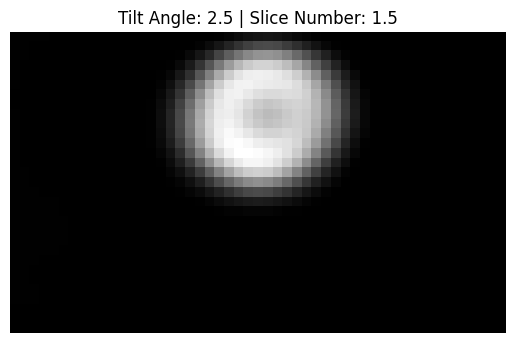

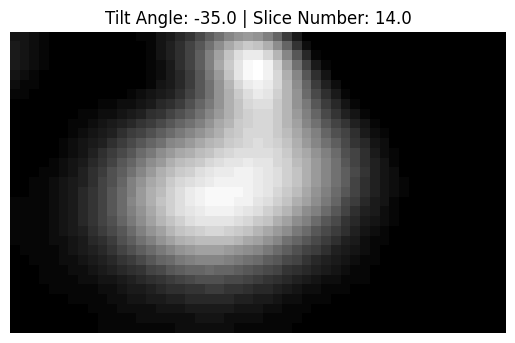

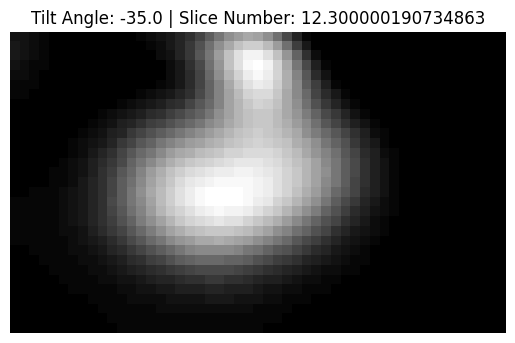

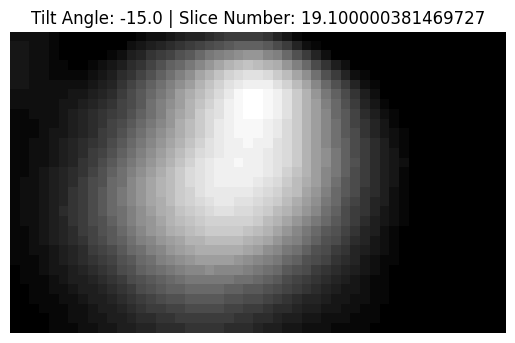

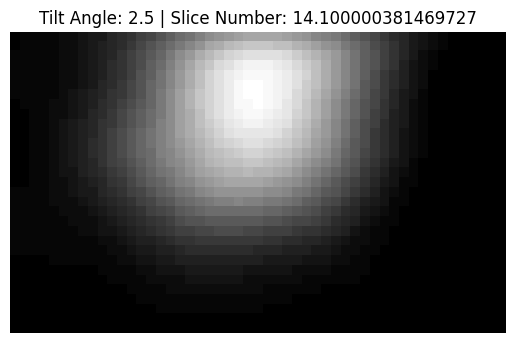

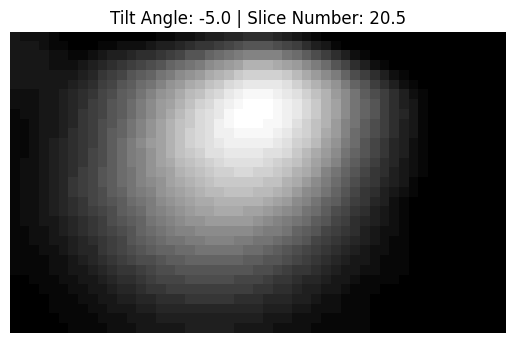

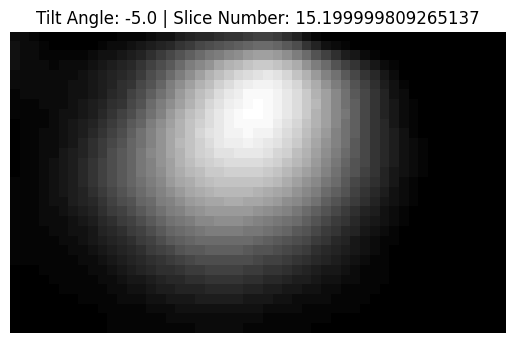

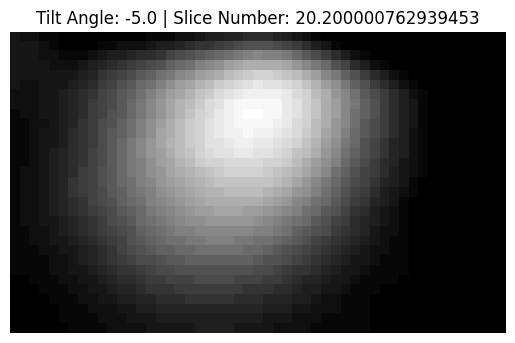

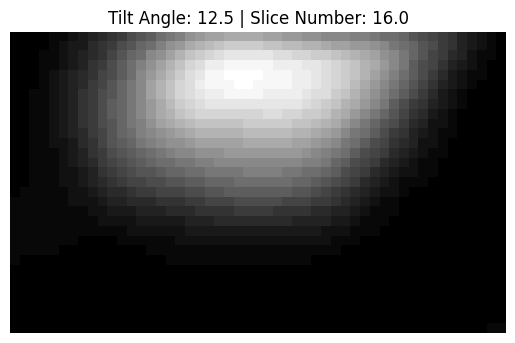

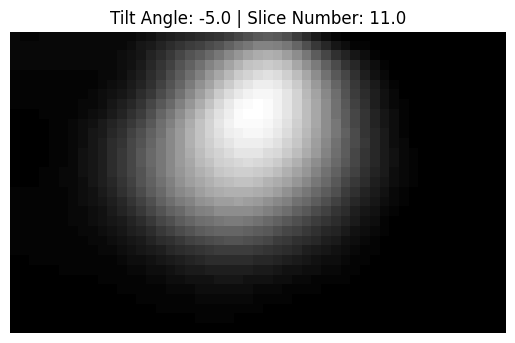

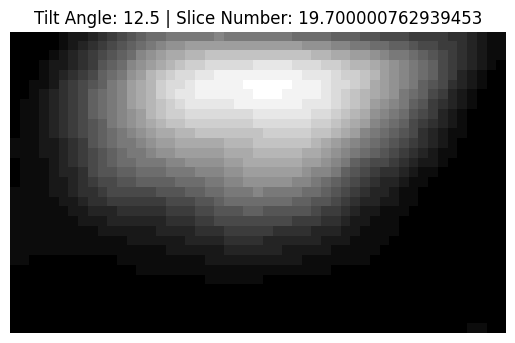

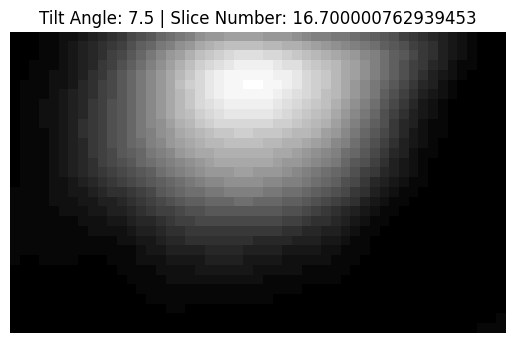

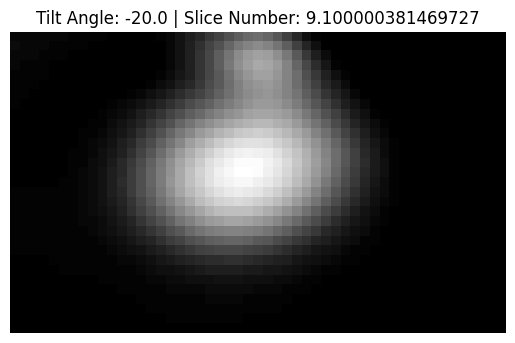

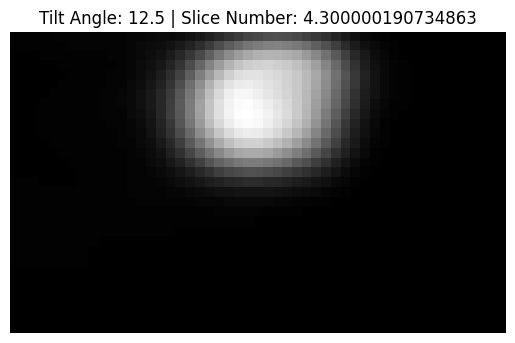

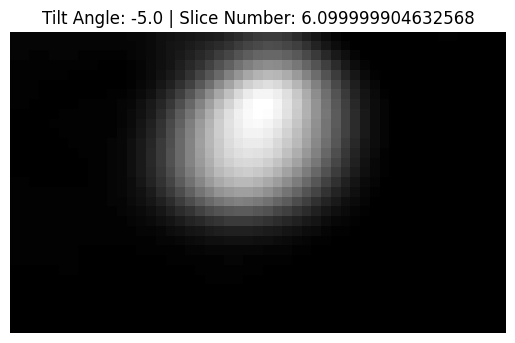

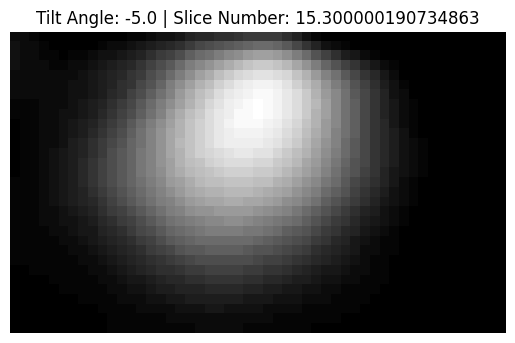

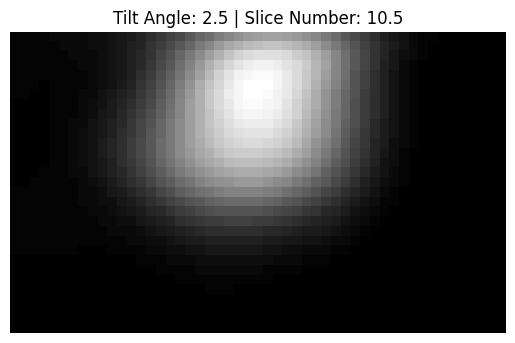

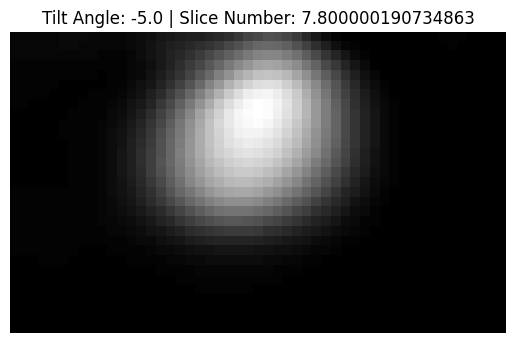

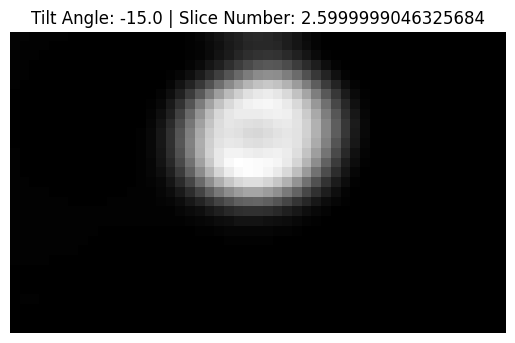

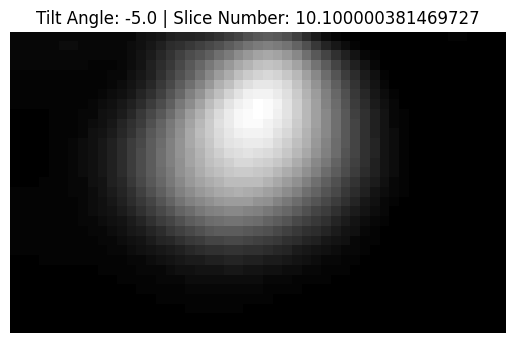

KeyboardInterrupt: 

In [ ]:
for images, tilt_angles, slice_numbers in val_loader:
    # Process the images, tilt angles, and slice numbers as needed
    batch_size = images.shape[0]
    for i in range(batch_size):
        # Display the image
        grayscale_image = images[i].mean(dim=0)

        plt.imshow(grayscale_image, cmap='gray')  # permute the dimensions to (height, width, channels)
        plt.title("Tilt Angle: {} | Slice Number: {}".format(tilt_angles[i], slice_numbers[i]))
        plt.axis('off')  # Turn off axis
        plt.show()
    break  # Break after processing the first batch

In [ ]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(2, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 31*51),
            nn.Tanh()  # Output in the range [-1, 1] for grayscale images
        )

    def forward(self, x):
      x = self.fc(x)
      x = x.view(-1, 1, 31, 51)
      return x

In [ ]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(2, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Linear(512, 31*51),
            # nn.BatchNorm1d(31*51),
            nn.Tanh()  # Output in the range [-1, 1] for grayscale images
        )

    def forward(self, x):
      x = self.fc(x)
      x = x.view(-1, 1, 31, 51)
      return x

In [ ]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(2, 128, kernel_size=3, stride=1, padding=1),  # Input channels: 2, Output channels: 128
            # nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),  # Input channels: 128, Output channels: 256
            # nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),  # Input channels: 256, Output channels: 512
            # nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 31*51, kernel_size=3, stride=1, padding=1),  # Input channels: 512, Output channels: 1 (Grayscale image)
            # Try Tanh instead of ReLU()
            # Try to add a few linear layers
            # Look at other loss functions other than MSE (look what other DNN image people are doing)
            nn.Tanh()  # Output in the range [-1, 1] for grayscale images
        )

    def forward(self, x):
        x = self.conv(x)
        # Crop the output to match the desired dimensions (31x51)
        x = x.view(-1, 1, 31, 51)
        return x


In [ ]:

class ConvBlock(nn.Module):
  def __init__(self, in_channels, out_channels, up_sample=False):
    super(ConvBlock, self).__init__()
    self.conv1 = nn.Conv2d(in_channels, out_channels, (3,3), padding=(1,1))
    self.conv2 = nn.Conv2d(out_channels, out_channels, (3,3), padding=(1,1))
    self.up_sample = up_sample
    if up_sample:
      # Up sample with up-conv 2x2, doubling along each dimension
      self.up = nn.ConvTranspose2d(out_channels, out_channels//2, 2, stride=2)
    # We do not want to down sample in the block, since we need the non-down-sampled output for skip connections

  def forward(self, input):
    x = F.relu(self.conv1(input))
    x = F.relu(self.conv2(x))
    if self.up_sample:
      x = self.up(x)
    return x

class Generator(nn.Module):
  def __init__(self):
    super(Generator, self).__init__()
    # Downsample convolution blocks
    self.dblock1 = ConvBlock(1, 64)
    self.dblock2 = ConvBlock(64, 128)
    self.dblock3 = ConvBlock(128, 256)
    self.dblock4 = ConvBlock(256, 512)
    # Upsample convolution blocks
    self.ublock1 = ConvBlock(512, 1024, True)
    # The next 4 blocks have doubled input channels due to concatination of skip connections
    self.ublock2 = ConvBlock(1024, 512, True)
    self.ublock3 = ConvBlock(512, 256, True)
    self.ublock4 = ConvBlock(256, 128, True)
    # Output "block"
    self.convf1 = nn.Conv2d(128, 64, (3,3), padding=(1,1))
    self.convf2 = nn.Conv2d(64, 64, (3,3), padding=(1,1))
    self.convf3 = nn.Conv2d(64, 1, (1,1), padding=(0,0))

    self.down = nn.MaxPool2d(2)

  def forward(self, input):
    # take input of 2x1 and get to 1 layer of 572x572
    input = F.pad(input, (285, 287, 285, 287), mode='constant', value=0)  # Pad symmetrically to achieve desired size


    # Save the last feature maps on each level! Pass an instance forward, but keep the variable referencing the same feature map for concatenation
    l1 = self.dblock1(input)
    l2 = self.dblock2(self.down(l1))
    l3 = self.dblock3(self.down(l2))
    l4 = self.dblock4(self.down(l3))
    # Concatinate l1 - l4 on inputs across the U in reverse order, matching sizes
    u = self.ublock1(self.down(l4))
    u = self.ublock2(torch.cat((l4, u), dim=1))
    u = self.ublock3(torch.cat((l3, u), dim=1))
    u = self.ublock4(torch.cat((l2, u), dim=1))
    out = F.relu(self.convf1(torch.cat((l1, u), dim=1)))
    out = F.relu(self.convf2(out))
    out = self.convf3(out)

    # go from output of 572x572 to 31x51
    out = F.interpolate(out, size=(31, 51), mode='bilinear', align_corners=True)

    return out


In [ ]:
def pixelwise_accuracy(y, y_truth):
  b = y.size(0)
  return (y.argmax(1).squeeze() == y_truth.squeeze()).float().view(b, -1).mean(1)


epoch:  0
epoch:  1
epoch:  2
epoch:  3
epoch:  4
epoch:  5
epoch:  6
epoch:  7
epoch:  8
epoch:  9
epoch:  10
epoch:  11
epoch:  12
epoch:  13
epoch:  14
epoch:  15
epoch:  16
epoch:  17
epoch:  18
epoch:  19
epoch:  20
epoch:  21
epoch:  22
epoch:  23
epoch:  24
epoch:  25
epoch:  26
epoch:  27
epoch:  28
epoch:  29
epoch:  30
epoch:  31
epoch:  32
epoch:  33
epoch:  34
epoch:  35
epoch:  36
epoch:  37
epoch:  38
epoch:  39
epoch:  40
epoch:  41
epoch:  42
epoch:  43
epoch:  44
epoch:  45
epoch:  46
epoch:  47
epoch:  48
epoch:  49
epoch:  50
epoch:  51
epoch:  52
epoch:  53
epoch:  54
epoch:  55
epoch:  56
epoch:  57
epoch:  58
epoch:  59
epoch:  60
epoch:  61
epoch:  62
epoch:  63
epoch:  64
epoch:  65
epoch:  66
epoch:  67
epoch:  68
epoch:  69
epoch:  70
epoch:  71
epoch:  72
epoch:  73
epoch:  74
epoch:  75
epoch:  76
epoch:  77
epoch:  78
epoch:  79
epoch:  80
epoch:  81
epoch:  82
epoch:  83
epoch:  84
epoch:  85
epoch:  86
epoch:  87
epoch:  88
epoch:  89
epoch:  90
epoch:  9

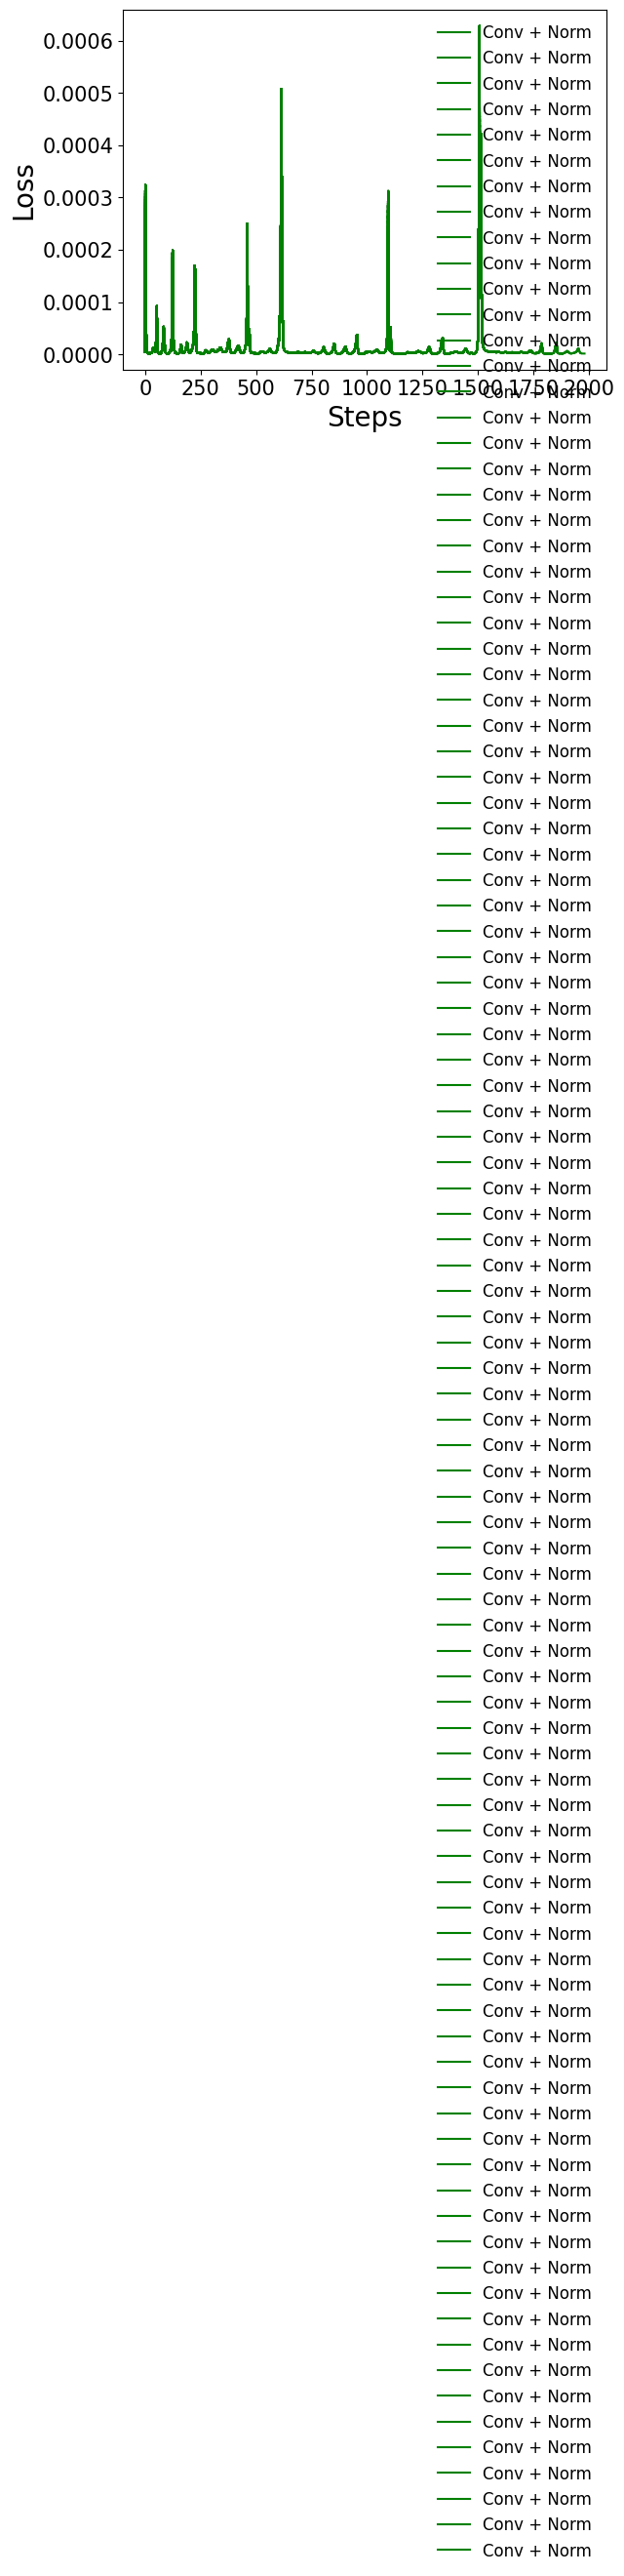

In [ ]:
# Training
input_size = 2  # Tilt angle and slice number
output_channels = 1  # Grayscale images
learning_rate = 0.0002
criterion = nn.MSELoss()
# criterion = ssim_loss()
Path = "/generator__2500_window_4_mse_3000.pth"
generator = Generator()
generator.load_state_dict(torch.load(Path))
optimizer = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
interval = 10
num_epochs = 2000

train_losses = []
train_accuracy = []
val_losses = []
val_losses_accuracy = []
j = 0

for epoch in range(num_epochs):
  print("epoch: ", epoch)
  for i, (images, tilt_angles, slice_numbers) in enumerate(train_loader):
    tilt_angles = tilt_angles.unsqueeze(1)
    slice_numbers = slice_numbers.unsqueeze(1)

    input_data = torch.cat((tilt_angles, slice_numbers), dim=1)
    # # comment this out when not using Unet
    # input_data = input_data.unsqueeze(-1).unsqueeze(-1)
    # # comment this out when not using layers of convolution
    # input_data = input_data.unsqueeze(2).unsqueeze(3)
    generated_image = generator(input_data)
    loss = criterion(generated_image, images)
    # loss = ssim_loss(generated_image, images)
    loss_mse = criterion(generated_image, images)
    train_losses.append(loss.item())
    # train_acc = pixelwise_accuracy(generated_image, images).mean()
    train_accuracy.append(loss_mse.item())

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (i+1) % interval == 0:
      print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'
                  .format(epoch+1, num_epochs, i+1, len(train_loader), loss.item()))
  # get the mean of the losses from running the validation loader
  vals = []
  vals_acc = []
  with torch.no_grad():
    for i, (images, tilt_angles, slice_numbers) in enumerate(val_loader):
      tilt_angles = tilt_angles.unsqueeze(1)
      slice_numbers = slice_numbers.unsqueeze(1)

      input_data = torch.cat((tilt_angles, slice_numbers), dim=1)
      # # Coment this out when not using Unet
      # input_data = input_data.unsqueeze(-1).unsqueeze(-1)

      # # comment this out when not using layers of convolution
      # input_data = input_data.unsqueeze(2).unsqueeze(3)
      generated_image = generator(input_data)
      loss = criterion(generated_image, images)
      # loss = ssim_loss(generated_image, images)
      loss_mse = criterion(generated_image, images)

      vals.append(loss.item())
      vals_acc.append(loss_mse.item())
    val_losses.append((len(train_losses), np.mean(vals)))
    val_losses_accuracy.append((len(train_losses), np.mean(vals_acc)))

    if j == 20:
      x, val = zip(*val_losses)
      plt.plot(train_losses, label='Conv + Norm', linestyle="solid", color="green")
      plt.plot(x, val, linestyle="dotted", color="green")
      # plt.ylim((0.0, 0.004))
      # plt.xlim((0.0, 500.0))
      plt.xlabel("Steps", fontsize = "20")
      plt.ylabel("Loss", fontsize = "20")
      plt.xticks(fontsize=15)
      plt.yticks(fontsize=15)
      plt.legend(frameon=False, fontsize='large')
      plt.savefig("normalized_linear.pdf")
      j = 0
  j += 1

In [ ]:
# Path = "/content/generator_window_5_1000.pth"

Path = "/generator__2500_window_4_mse_5000.pth"

# Save the trained model
torch.save(generator.state_dict(), Path)


In [ ]:
x, val = zip(*val_losses)
# train_losses_van = train_losses
# x_van = x
# val_van = val

x_acc, val_acc = zip(*val_losses_accuracy)

In [ ]:
x_nonorm, val_nonorm = zip(*val_losses)
# train_a = train_losses
# x_van = x
# val_van = val

x_acc_nonorm, val_acc_nonorm = zip(*val_losses_accuracy)

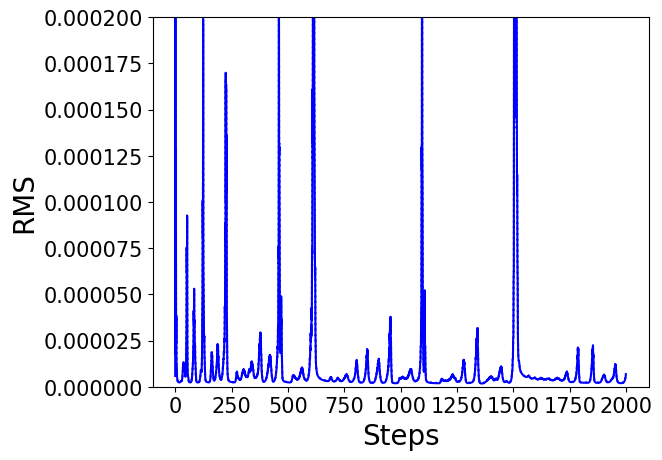

In [ ]:
# x, val = zip(*val_losses)
# plt.plot(train_losses, label='SSIM', linestyle="solid", color="green")
# plt.plot(x, val, linestyle="dotted", color="green")
plt.plot(train_accuracy, label="MSE", linestyle ="solid", color="blue")
plt.plot(x_acc, val_acc, linestyle="dotted", color="blue")
# plt.plot(train_accuracy, label="MSE", linestyle ="solid", color="blue")
# plt.plot(x_acc_nonorm, val_acc_nonorm, linestyle="dotted", color="blue")
# plt.plot(train_losses_norm, label='Linear + Norm', linestyle="solid", color="red")
# plt.plot(x_norm, val_norm, linestyle="dotted", color="red")
# plt.plot(train_losses_van, label='Linear', linestyle="solid", color="blue")
# plt.plot(x_van, val_van, linestyle="dotted", color="blue")
plt.ylim((0.0, 0.0002))
# plt.xlim((0.0, 500.0))
plt.xlabel("Steps", fontsize = "20")
plt.ylabel("RMS", fontsize = "20")
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
# plt.legend(frameon=False, fontsize='large')
# plt.savefig("normalized_linear.pdf")
plt.savefig("SSIM_MSE_loss_test.png")

# save array:
np.save('train_accuracy_test.npy', train_accuracy)
np.save('x_acc_test.npy', x_acc)
np.save('val_acc_test.npy', val_acc)

# plt.plot(train_losses_van, label='Train Normalized', linestyle="solid", color="blue")
# plt.show()
# plt.plot(train_accuracy, label='train')
# # plt.plot(x, val, label='val')
# plt.title("Pixelwise Accuracy")
# plt.xlabel("Steps")
# plt.ylabel("Accuracy")
# plt.legend()
# plt.show()

tilt_angles[i]:  tensor(12.5000) 

slice_numbers[i]:  tensor(1.5000) 



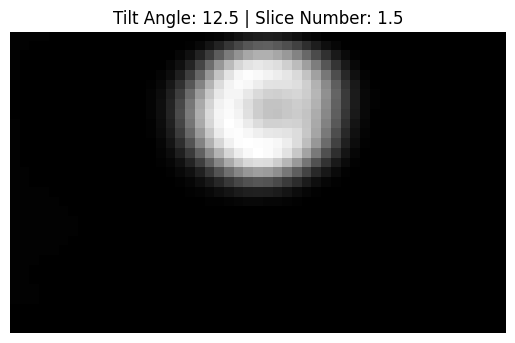

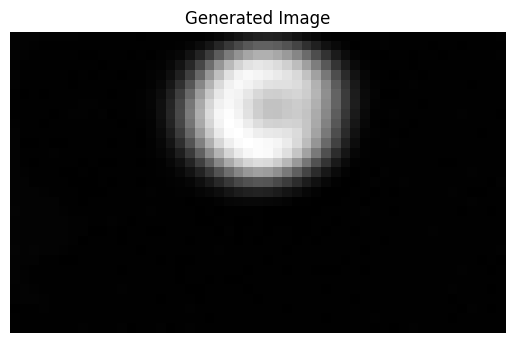

In [ ]:
# time to plot an image
import matplotlib.pyplot as plt
# Set the generator to evaluation mode
generator.eval()
# tilt = 2.5
# slice_number = 7.0

# # Generate an example image
# with torch.no_grad():
#     # Assuming you have a sample of tilt angles and slice numbers
#     tilt_angle = torch.tensor([tilt])  # Example tilt angle
#     slice_number = torch.tensor([slice_number])  # Example slice number
#     input_data = torch.cat((tilt_angle.unsqueeze(1), slice_number.unsqueeze(1)), dim=1)
#     # # comment this out when not using layers of convolution
#     # input_data = input_data.unsqueeze(2).unsqueeze(3)
#     generated_image = generator(input_data)

# # Plot the generated image
# generated_image = generated_image.squeeze().numpy()  # Convert to NumPy array and remove single-dimensional entries

# plt.imshow(generated_image, cmap='gray')
# plt.title("Generated Image")
# plt.axis('off')
# plt.show()

# # np.save('generated_image_tilt_'+np.string(tilt)+'_slice_'+np.string(slice_number)+'.npy', generated_image)
# filename = f'generated_image_tilt_{tilt}_slice_{slice_number}.npy'
# np.save(filename, generated_image)

# with torch.no_grad():
#     # Assuming you have a sample of tilt angles and slice numbers
#     tilt_angle = torch.tensor([tilt])  # Example tilt angle
#     slice_number = torch.tensor([slice_number])  # Example slice number
#     input_data = torch.cat((tilt_angle.unsqueeze(1), slice_number.unsqueeze(1)), dim=1)
#     # # comment this out when not using layers of convolution
#     # input_data = input_data.unsqueeze(2).unsqueeze(3)
#     generated_image = generator(input_data)

# # Plot the generated image
# generated_image = generated_image.squeeze().numpy()  # Convert to NumPy array and remove single-dimensional entries

# plt.imshow(generated_image, cmap='gray')
# plt.title("Generated Image")
# plt.axis('off')
# plt.show()

# np.save('generated_image_tilt_7_5_slice_12.npy', generated_image)

for images, tilt_angles, slice_numbers in Total_loader:
    # Process the images, tilt angles, and slice numbers as needed
    batch_size = images.shape[0]
    # print("slice_numbers: ", slice_numbers)
    # print("tilt_angles: ", torch.min(tilt_angles))
    for i in range(batch_size):
        # print("i: ", i, "\n")

        # tilt 5, slice 9
        # 5, 7
        # 7.5, 7
        # 7.5, 11
        # 7.5, 12
        # 10.0, 12
        # 10.0, 10
        # 10.0, 9
        # 10.0, 8
        # 12.5, 7
        # 12.5, 8
        # 12.5, 12
        #


        if tilt_angles[i] == 12.5:
          if slice_numbers[i] == 1.5:
            print("tilt_angles[i]: ", tilt_angles[i], "\n")
            print("slice_numbers[i]: ", slice_numbers[i], "\n")
            # Display the image
            grayscale_image = images[i].mean(dim=0)

            plt.imshow(grayscale_image, cmap='gray')  # permute the dimensions to (height, width, channels)
            plt.title("Tilt Angle: {} | Slice Number: {}".format(tilt_angles[i], slice_numbers[i]))
            plt.axis('off')  # Turn off axis
            plt.show()

            filename = f'source_image_tilt_{tilt_angles[i]}_slice_{slice_numbers[i]}.npy'
            np.save(filename, grayscale_image)

            # Generate an example image
            with torch.no_grad():
                # Assuming you have a sample of tilt angles and slice numbers
                tilt_angle = torch.tensor([tilt_angles[i]])  # Example tilt angle
                slice_number = torch.tensor([slice_numbers[i]])  # Example slice number
                input_data = torch.cat((tilt_angle.unsqueeze(1), slice_number.unsqueeze(1)), dim=1)
                # # comment this out when not using layers of convolution
                # input_data = input_data.unsqueeze(2).unsqueeze(3)
                generated_image = generator(input_data)

            generated_image = generated_image.squeeze().numpy()  # Convert to NumPy array and remove single-dimensional entries

            plt.imshow(generated_image, cmap='gray')
            plt.title("Generated Image")
            plt.axis('off')
            plt.show()

            filename = f'generated_image_tilt_{tilt_angles[i]}_slice_{slice_numbers[i]}.npy'
            np.save(filename, generated_image)

    break  # Break after processing the first batch

In [ ]:
Path = "/content/generator__2500_window_4_mse_5000.pth"

# # save model
# torch.save(generator, Path)

# # load model
# model = torch.save(generator, Path)
# model.eval()

# Save the trained model
# torch.save(generator.state_dict(), Path)

# Later, to load the model
# Create a new instance of the model
generator = Generator()

# # Load the state dictionary into the model
generator.load_state_dict(torch.load(Path))

# # Set the model to evaluation mode
generator.eval()

# Now you can use `generator` to generate images

Generator(
  (fc): Sequential(
    (0): Linear(in_features=2, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=512, bias=True)
    (5): ReLU()
    (6): Linear(in_features=512, out_features=1581, bias=True)
    (7): Tanh()
  )
)